## Решение линейных систем, обратная матрица

### Напоминание основных фактов

- Линейная система имеет вид

$$ Ax = b,$$

с квадратной $n \times n$ матрицей $A$

- Для любой матрицы существуют PLU разложение

$$ A = PLU, $$

$P$ – матрица перестановки, $L$ – нижнетреугольная матрица, $U$ – верхнетреугольная матрица.

- Сложность $\mathcal{O}(n^3)$
- Если $A \succ 0$, то матрица раскладывается на факторы $A = LL^*$ – разложение Холецкого 
- Обратная матрица $A^{-1}$ существует для невырожденных матриц и $AA^{-1} = A^{-1}A = I$
- Тогда $x = A^{-1}b$ или $x = U^{-1}L^{-1}P^*b$

### Push-through identity

- Дано $A \in \mathbb{R}^{m \times n}$, $B \in \mathbb{R}^{n \times m}$ и $I + AB$ обратима
- Покажем, что и $I + BA$ обратима
- Также покажем, что $(I + BA)^{-1}B = B(I + AB)^{-1}$ 

### Формула Шермана-Морисона-Вудбери

- $(I+P)^{-1} = I - (I+P)^{-1}P = I - P(I+P)^{-1}$
- Ранее доказанное утверждение $(I + BA)^{-1}B = B(I + AB)^{-1}$ 
- Применим к $(I + UV)^{-1} = I - UV(I + UV)^{-1} = I - U(I + VU)^{-1}V$
- Формула Шермана-Морисона-Вудбери

$$(A + UCV)^{-1} = A^{-1} - A^{-1}U (C^{-1} + VA^{-1}U)^{-1}VA^{-1} $$

### Определение координат по дополнительным измерениям

- Дано положение 4 объектов в пространстве $a_1$, $a_2$, $a_3$ и $a_4$
- Известны расстояния между ними и искомым объектом $x$: $r_1$, $r_2$, $r_3$ и $r_4$
- Как определить положение $x$?

### Выигрыш от LU факторизации при решении систем с многими правыми частями

- Дан набор систем $Ax = b_1$, $Ax = b_2, \ldots$
- Посмотрим на выигрыш в скорости при использовании однократной факторизации матрицы $A$

In [25]:
n = 1000
time_factor = []
time_full = []
A = np.random.randn(n, n)
t = %timeit -o -q -r 5 splin.lu_factor(A)
factor_time = t.best
lu = splin.lu_factor(A)
num_rhs = 10
for i in range(num_rhs):
    x_true = np.random.randn(n)
    b = A @ x_true
    t = %timeit -o -q np.linalg.solve(A, b)
    time_full.append(t.best)
    t = %timeit -o -q splin.lu_solve(lu, b)
    time_factor.append(t.best)

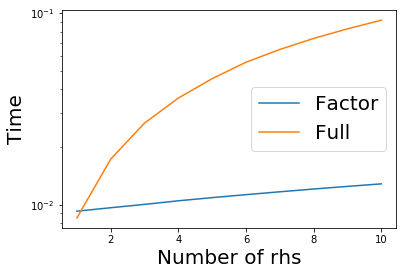

In [34]:
plt.plot(np.arange(1, num_rhs+1), factor_time + np.cumsum(np.array(time_factor)), label="Factor")
plt.plot(np.arange(1, num_rhs+1), np.cumsum(np.array(time_full)), label="Full")
plt.legend(fontsize=20)
plt.xlabel("Number of rhs", fontsize=20)
plt.ylabel("Time", fontsize=20)
plt.yscale("log")

## Постановка линейной задачи наименьших квадратов: напоминание

- Дана переопределённая система линейных уравнений с матрицей $A$, в которой строк больше, чем столбцов, и правой частью $b$
- Задача решения такой системы в смысле наименьших квадратов записывается в виде


$$\Vert A x - b \Vert_2 \rightarrow \min_{x}$$

- Нормальное уравнение

$$ A^* A x = A^* b $$

## Решение и метод вычисления

- Псевдообратная матрица 

$$A^{\dagger} = \lim_{\alpha \rightarrow 0}(\alpha I + A^* A)^{-1} A^*$$ 

- Решение записывается как 

$$ x = A^{\dagger}b $$

- Вычисление псевдообратной матрицы из SVD

    Пусть $A = U \Sigma V^*$ SVD матрицы $A$. Тогда,

    $$A^{\dagger} = V \Sigma^{\dagger} U^*,$$

    где $\Sigma^{\dagger}$ состоит из обращённых ненулевых сингулярных чисел матрицы $A$.

- Решение вычисляется с помощью QR разложения матрицы $A$

$$
Rx = Q^* b.
$$

### Сравнение методов решения нормального уравнения

- Метод Гаусса
- QR разложение

#### Сравниваем скорость

In [1]:
import numpy as np
import scipy.linalg as splin

def lsqr_solver(A, b):
    Q, R = np.linalg.qr(A)
    return splin.solve_triangular(R, Q.T @ b, lower=False)
#     return np.linalg.solve(R, Q.T @ b)

def ls_gramm_solver(A, b):
    gram_mat = A.T @ A
    return np.linalg.solve(gram_mat, A.T @ b)

In [2]:
n = 1000
m = 10*n
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.001 * np.random.randn(m)
x = lsqr_solver(A, b)
print(np.linalg.norm(A @ x - b), np.linalg.norm(x - x_true) / np.linalg.norm(x_true))
x = ls_gramm_solver(A, b)
print(np.linalg.norm(A @ x - b), np.linalg.norm(x - x_true) / np.linalg.norm(x_true))

0.0941568577038455 1.1125550186578408e-05
0.0941568577038517 1.1125550186578575e-05


In [9]:
dim_range = [10**i for i in range(1, 4)]
time_qr_range = []
time_gram_range = []
for n in dim_range:
    m = 10*n
    A = np.random.randn(m, n)
    x_true = np.random.randn(n)
    b = A @ x_true + 0 * np.random.randn(m)
    t = %timeit -o -q -r 1 lsqr_solver(A, b) 
    time_qr_range.append(t.best)
    t = %timeit -o -q -r 1 ls_gramm_solver(A, b)
    time_gram_range.append(t.best)

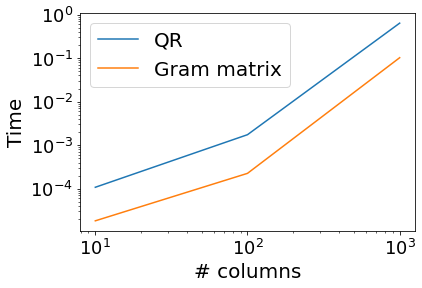

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dim_range, time_qr_range, label="QR")
plt.plot(dim_range, time_gram_range, label="Gram matrix")
plt.legend(fontsize=20)
plt.xlabel("# columns", fontsize=20)
plt.ylabel("Time", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

#### Сравниваем устойчивость
- Оценка из лекции
$$ 
\frac{\Vert \widehat{x} - x \Vert}{\Vert x \Vert} \leq \frac{\mathrm{cond}(A)}{1 - \mathrm{cond}(A)\frac{\|\Delta A\|}{\|A\|}} \Big(\frac{\Vert\Delta A\Vert}{\Vert A \Vert} + \frac{\Vert \Delta f \Vert}{ \Vert f \Vert}\Big) $$

In [34]:
eps_range = [10**(-i) for i in range(1, 8)]
m = 1000
n = 100
A = np.random.randn(m, n)
accuracy_qr = np.zeros(len(eps_range))
accuracy_gram = np.zeros(len(eps_range))
cond_range = np.zeros(len(eps_range))
for i, eps in enumerate(eps_range):
    u, s, v = np.linalg.svd(A, full_matrices=False)
    s_bad = s.copy()
    s_bad[-1] = eps
    cond_range[i] = s_bad[0] / s_bad[-1]
    A_bad = (u * s_bad) @ v
    x_true = np.random.randn(n)
    b = A_bad @ x_true
    x = lsqr_solver(A_bad, b)
    accuracy_qr[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    x = ls_gramm_solver(A_bad, b)
    accuracy_gram[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    

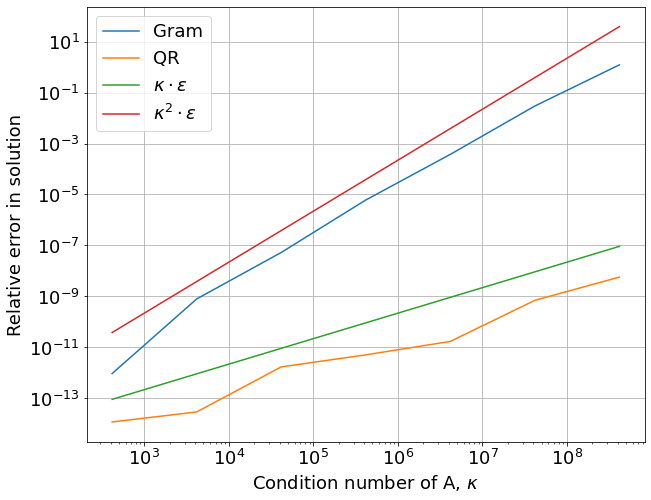

In [35]:
plt.figure(figsize=(10,8))
plt.plot(cond_range, accuracy_gram, label="Gram")
plt.plot(cond_range, accuracy_qr, label="QR")
plt.plot(cond_range, cond_range * np.finfo(np.float64).eps, label="$\kappa \cdot \epsilon$")
plt.plot(cond_range, cond_range**2 * np.finfo(np.float64).eps, label="$\kappa^2 \cdot \epsilon$")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Condition number of A, $\kappa$", fontsize=18)
plt.ylabel("Relative error in solution", fontsize=18)
plt.grid(True)

### Закон Мура

- Количество транзисторов на интегральной схеме удваивается каждые полтора-два года

In [3]:
import pandas as pd

year_transistor = {
1971: 2250,
1972: 2500,
1974: 5000,
1978: 29000,
1982: 120000,
1985: 275000,
1989: 1180000,
1993: 3100000,
1997: 7500000,
1999: 24000000,
2000: 42000000,
2002: 220000000,
2003: 410000000
}

data = pd.DataFrame([year_transistor])
data

,1971,1972,1974,1978,1982,1985,1989,1993,1997,1999,2000,2002,2003
0,2250,2500,5000,29000,120000,275000,1180000,3100000,7500000,24000000,42000000,220000000,410000000


In [4]:
data = pd.DataFrame(list(year_transistor.items()), columns=["Year", "N"])
data

,Year,N
0,1971,2250
1,1972,2500
2,1974,5000
3,1978,29000
4,1982,120000
5,1985,275000
6,1989,1180000
7,1993,3100000
8,1997,7500000
9,1999,24000000


### Модель

$$ \log_{2} N \approx  w_1 + w_2 (t - 1970)$$

- Логарифмирование – очень полезный приём преобразования данных, масштабы которых сильно отличаются 

In [5]:
y = np.log2(data["N"])
x = data["Year"] - 1970
X = np.ones((13, 2))
X[:, 1] = x
print(X)
print(y)

[[ 1.  1.]
 [ 1.  2.]
 [ 1.  4.]
 [ 1.  8.]
 [ 1. 12.]
 [ 1. 15.]
 [ 1. 19.]
 [ 1. 23.]
 [ 1. 27.]
 [ 1. 29.]
 [ 1. 30.]
 [ 1. 32.]
 [ 1. 33.]]
0     11.135709
1     11.287712
2     12.287712
3     14.823765
4     16.872675
5     18.069072
6     20.170355
7     21.563837
8     22.838459
9     24.516531
10    25.323886
11    27.712928
12    28.611049
Name: N, dtype: float64


In [8]:
w = np.linalg.lstsq(X, y, rcond=None)[0]
print(np.linalg.norm(X @ w - y))
print(w)

2.4323270736375635
[10.38299398  0.51163732]


Text(0, 0.5, 'log # transistors')

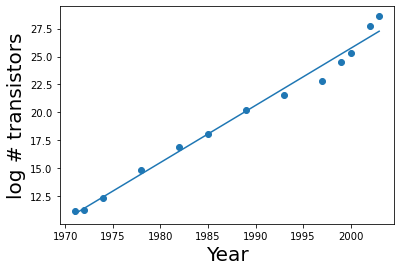

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data["Year"], y)
plt.plot(data["Year"], X @ w)
plt.xlabel("Year", fontsize=20)
plt.ylabel("log # transistors", fontsize=20)

### Предсказание на 2015 год

- Микропроцессор IBM Z13 содержит $4 \cdot 10^9$ транзисторов

In [10]:
year = 2015
pred_given_year = w[0] + w[1] * (year - 1970)
print(pred_given_year)
print(np.log2(4e9))

33.40667332708807
31.897352853986263
